In [2]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))


import torch
import torch.nn as nn
import torchvision.transforms as transforms

from vision_transformer.VisionTransformer import ViT
from src.read_config import read_config

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
class TransformerClassifier(nn.Module): 
    def __init__(self, n_classes, img_size: int, in_channels: int, transformer_config): 
        super().__init__()
        
        self.n_classes = n_classes
        self.img_size = img_size
        self.in_channels = in_channels
        self.transformer_config = transformer_config
        
        self.vit = ViT(img_size=img_size, in_channels=in_channels, **self.transformer_config)

        self.classifier = nn.Sequential(
            nn.Linear(self.vit.d_model, self.n_classes), 
            nn.ReLU(), 
        )
        
    def forward(self, x): 
        embeddins = self.vit(x)
        logits = self.classifier(embeddins)
        
        return logits

In [4]:
name = 'architecture_2.yaml'
config = read_config(config_path='../configs', config_name=name)

model = TransformerClassifier(n_classes=101, img_size=96, in_channels=3, transformer_config=config['params'])
model.load_state_dict(torch.load('architecture_2.pth', weights_only=True))

for p in model.parameters():
        p.requires_grad = False
        
model.eval()

config

{'inputs': {'img_size': 96, 'in_channels': 3}, 'params': {'patch_size': 8, 'd_model': 512, 'dropout_rate': 0.5, 'n_encoder_blocks': 2, 'n_heads': 4, 'ff_size': 1024}}

In [5]:
from PIL import Image

image = Image.open("data/testing_images/cat.jpg")
transform = transforms.Compose([transforms.PILToTensor()])
img_tensor = transform(image)/255

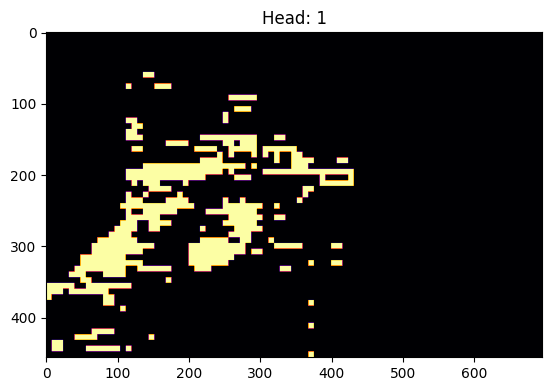

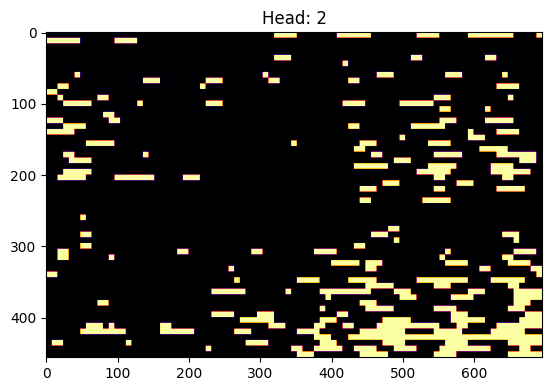

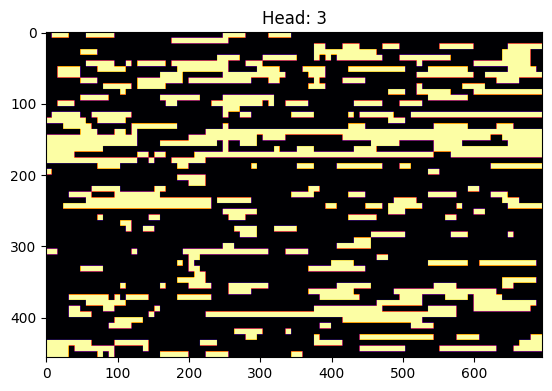

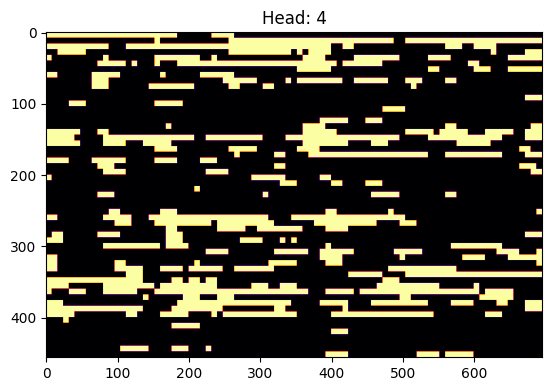

In [8]:
def thresholded_attention_interpretation(transformer, image, threshold=0.5): 
    patch_size = transformer.embedder.patch_size
    w, h = image.shape[1] - image.shape[1] % patch_size, image.shape[2] - image.shape[2] % patch_size
    image = image[:, :w, :h]
    
    data = transformer.interpret(image)
    
    w_featmap = image.shape[-2] // patch_size
    h_featmap = image.shape[-1] // patch_size
    nh = transformer.n_heads
    
    # (h, w_featmap, w_featmap)
    attentions = torch.stack(data['encoders'][-1]['heads']['raw'])
    
    attentions = attentions.reshape(nh, -1)
    # we keep only a certain percentage of the mass
    val, idx = torch.sort(attentions)
    val /= torch.sum(val, dim=1, keepdim=True)
    cumval = torch.cumsum(val, dim=1)
    th_attn = cumval > (1 - threshold)
    idx2 = torch.argsort(idx)
    for head in range(nh):
        th_attn[head] = th_attn[head][idx2[head]]
    th_attn = th_attn.reshape(nh, w_featmap, h_featmap).float()
    
    # interpolate
    th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
            
    for head_id, head_norm in enumerate(th_attn, 1):
        plt.title(f'Head: {head_id}')
        plt.imshow(head_norm, cmap='inferno')
        plt.show()
    
thresholded_attention_interpretation(model.vit, img_tensor, threshold=0.5)

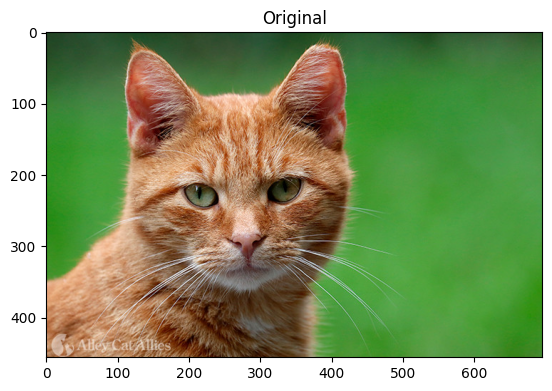

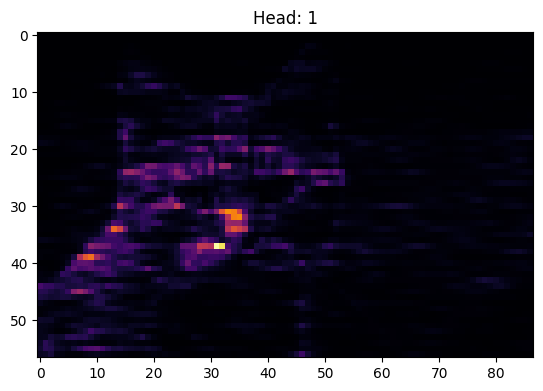

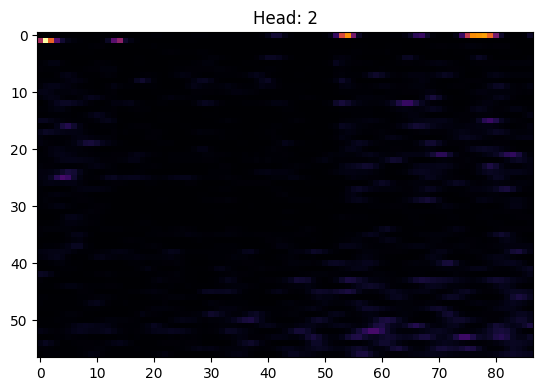

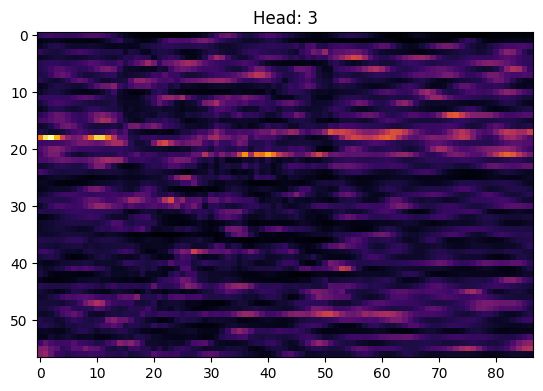

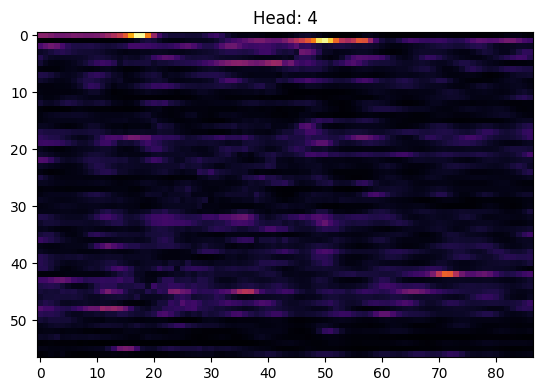

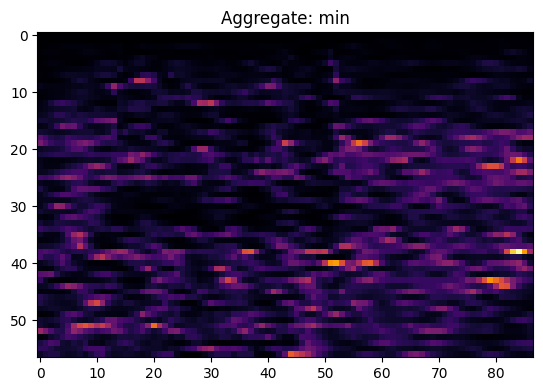

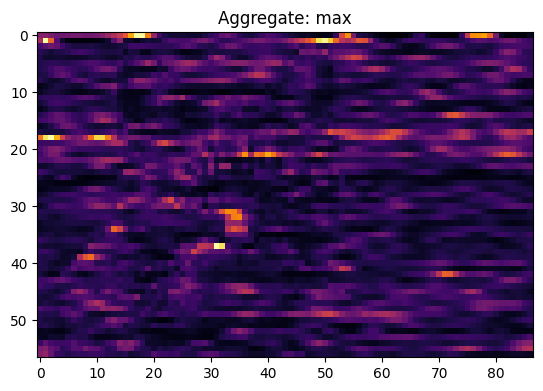

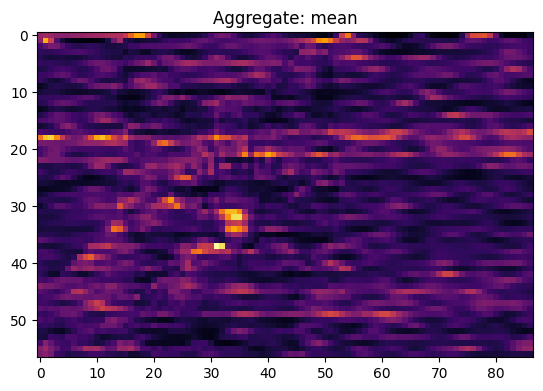

In [7]:
def interpret_attention(transformer, image):
    w, h = image.shape[1] - image.shape[1] % transformer.embedder.patch_size, image.shape[2] - image.shape[2] % transformer.embedder.patch_size
    image = image[:, :w, :h]
    
    data = transformer.interpret(image)
    
    plt.title('Original')
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.show()

    for head_id, head_norm in enumerate(data['encoders'][-1]['heads']['normalized'], 1):
        head_norm = head_norm.detach().cpu().numpy()
        plt.title(f'Head: {head_id}')
        plt.imshow(head_norm, cmap='inferno')
        plt.show()
        
    for agg_type, data in data['encoders'][-1]['aggregated'].items():
        plt.title(f'Aggregate: {agg_type}')
        plt.imshow(data, cmap='inferno')
        plt.show()
        
interpret_attention(model.vit, img_tensor)